# Моделирование изменения балансов студентов

**Основная задача** — Для онлайн-университета необходимо смоделировать систему, отслеживающию изменение балансов студентов.
Баланс — это количество оплаченных уроков, которые есть на счету у каджого студента. 
В результате получится запрос, который собирает данные о балансах студентов за каждый "прожитый" ими день.  

**Дополнительная задача** — Сделать таблицу с финальными балансами студентов на конец календарного года. Так можно будет оценить, какое количество студентов имеет отрицательный баланс.

Нам важно понимать: 
- сколько всего уроков было на балансе всех учеников за каждый календарный день;
- как это количество менялось под влиянием транзакций (оплат, начислений, корректирующих списаний) и уроков (списаний с баланса по мере прохождения уроков).




***Описание витрины с платежами по урокам.***

- **user_id** *—* уникальный идентификатор юзера.
- **id_transaction** *—* уникальный идентификатор транзакции.
- **operation_name** *—* название проведенной операции.
- **status_name** *—* статус проведенной операции (исполнена / не исполнена и т. д.).
- **classes** *—* количество оплаченных уроков.
- **payment_amount** *—* выплаченная сумма.
- **transaction_datetime** *—* время проведения операции.

***Описание витрины с уроками.***

- **user_id** *—*  уникальный идентификатор юзера.
- **id_class** *—* уникальный идентификатор урока.
- **class_start_datetime** *—* время начала урока.
- **class_end_datetime** *—* время конца урока.
- **class_removed_datetime** *—* время удаления записи о данном уроке.
- **id_teacher** *—* уникальный идентификатор учителя.
- **class_status** *—* статус урока (успешно проведен / отменен и т. д.).
- **class_status_datetime** *—* время проставления статуса по уроку.

### Шаг 1.  
Узнаем, когда была первая транзакция для каждого студента. Начиная с этой даты, мы будем собирать его баланс уроков. 
Создадим CTE `first_payments` с двумя полями: user_id и first_payment_date (дата первой успешной транзакции). 

In [ ]:
with 
    first_payments as 
(
select user_id,
        min(transaction_datetime::date) as first_payment_date
from skyeng_db.payments
group by user_id
),

### Шаг 2.  
Соберем таблицу с датами за каждый календарный день 2016 года. Выберем все даты из таблицы classes, создадим CTE `all_dates` с полем dt, где будут храниться уникальные даты (без времени) уроков. 

In [ ]:
 all_dates as 
(
select distinct date(class_start_datetime) as dt
from skyeng_db.classes
where date_trunc('year',class_start_datetime) = '2016-01-01'
),

### Шаг 3.  
Узнаем, за какие даты имеет смысл собирать баланс для каждого студента. Для этого объединим таблицы и создадим CTE `all_dates_by_user`, где будут храниться все даты жизни студента после того, как произошла его первая транзакция. 

In [ ]:
all_dates_by_user as 
( 
select user_id,
       dt
from all_dates a
join first_payments f
  on f.first_payment_date <= a.dt
),

### Шаг 4.  
Найдем все изменения балансов, связанные с успешными транзакциями. Выберем все транзакции из таблицы `payments`, сгруппируем их по user_id и дате транзакции (без времени) и найдем сумму по полю classes. 
В результате получим CTE `payments_by_dates` с полями: user_id, payment_date, transaction_balance_change (сколько уроков было начислено или списано в этот день). 

In [ ]:
payments_by_dates as 
(
select user_id,
      date(transaction_datetime) as payment_date,
      sum(classes) as transaction_balance_change
from skyeng_db.payments
where status_name = 'success' 
group by user_id, payment_date 
),

### Шаг 5.  
Найдем баланс студентов, который сформирован только транзакциями. Для этого объединим `all_dates_by_user` и `payments_by_dates` так, чтобы совпадали даты и user_id. Используем оконные выражения (функцию sum), чтобы найти кумулятивную сумму по полю transaction_balance_change для всех строк до текущей включительно с разбивкой по user_id и сортировкой по dt. 
В результате получим CTE `payments_by_dates_cumsum` с полями: user_id, dt, transaction_balance_change — transaction_balance_change_cs (кумулятивная сумма по transaction_balance_change). При подсчете кумулятивной суммы заменим пустые значения нулями.

In [ ]:
payments_by_dates_cumsum as
(
select a.user_id,
       dt,
       coalesce(transaction_balance_change, 0) as transaction_balance_change,
       coalesce(sum(transaction_balance_change) over (partition by a.user_id order by dt),0) as transaction_balance_change_cs
       from all_dates_by_user a
left join payments_by_dates p
    on a.user_id = p.user_id
    and a.dt = p.payment_date

### Шаг 6.  
Найдем изменения балансов из-за прохождения уроков. 
Создадим CTE `classes_by_dates`, посчитав в таблице `classes` количество уроков за каждый день для каждого ученика. 
Нас не интересуют вводные уроки и уроки со статусом, отличным от success и failed_by_student. 
Получим результат с такими полями: user_id, class_date, classes (количество пройденных в этот день уроков). Причем classes мы умножим на -1, чтобы отразить, что - — это списания с баланса.

In [ ]:
classes_by_dates as 
(
select user_id,
    date_trunc('day',class_start_datetime) as class_date,
    count(id_class) * -1 as classes
from skyeng_db.classes
where class_status in ('success', 'failed_by_student') 
  and class_type <> 'trial' 
group by user_id, class_date
),

### Шаг 7.  
По аналогии с уже проделанным шагом для оплат создадим CTE для хранения кумулятивной суммы количества пройденных уроков. 
Для этого объединим таблицы `all_dates_by_user` и `classes_by_dates` так, чтобы совпадали даты и user_id. Используем оконные выражения (функцию sum), чтобы найти кумулятивную сумму по полю classes для всех строк до текущей включительно с разбивкой по user_id и сортировкой по dt. 
В результате получим CTE `classes_by_dates_dates_cumsum` полями: user_id, dt, classes — classes_cs(кумулятивная сумма по classes). 

In [ ]:
 classes_by_dates_cumsum as 
(
 select a.user_id,
       dt,
       coalesce(classes, 0) as classes,
       coalesce(sum(classes) over (partition by a.user_id order by dt),0) as classes_cs
from all_dates_by_user a
left join classes_by_dates cl
    on a.user_id = cl.user_id
    and a.dt = cl.class_date
),

### Шаг 8.  
Создадим CTE `balances` с вычисленными балансами каждого студента. Для этого объединим таблицы `payments_by_dates_cumsum` и `classes_by_dates_dates_cumsum` так, чтобы совпадали даты и user_id.

In [ ]:
balances as
 (
 select pd.*,
        classes,
        classes_cs,
        classes_cs + transaction_balance_change_cs as balance
 from payments_by_dates_cumsum pd
 join classes_by_dates_cumsum cd
    on pd.user_id = cd.user_id
    and pd.dt = cd.dt

### Шаг 9.   
Посмотрим, как менялось общее количество уроков на балансах студентов.
Для этого просуммируем поля `transaction_balance_change`, `transaction_balance_change_cs`, `classes`, `classes_cs`, `balance` из CTE `balances` с группировкой и сортировкой по `dt`.

In [ ]:
select dt,
    sum(transaction_balance_change) as sum_transaction,
    sum(transaction_balance_change_cs) as sum_transaction_cs,
    sum(classes) as sum_classes,
    sum(classes_cs) as sum_classes_cs,
    sum(balance) as sum_balance
from balances 
group by dt
order by dt

### Шаг 9.1*.    
Узнаем максимальный и минимальный уровень баланса на конец года среди всех студентов. На основе полученных данных, сделаем разбивку от - 80 до 80, с шагом 20.

In [ ]:
select case  when balance between -80 and -60 then '-80'
      when balance between -60 and -40 then '-60'
      when balance between -40 and -20 then '-40'
      when balance between -20 and -1 then '-20'
      when balance = 0 then '0'
      when balance between 1 and 20 then '20'
      when balance between 20 and 40 then '40'
      when balance between 40 and 60 then '60'
      when balance between 60 and 80 then '80'
      else '> 80'
      end as balances_bin,
      count(*) as cnt_students
from (select *,
     row_number() over (partition by user_id order by dt desc) as row
     from  balances) a
where row = 1
group by balances_bin
order by 1

### Шаг 10. Визуализация и выводы  
Визуализируем полученные данные. 
- По визуализации мы можем наблюдать рост по графе sum_transactions, которая отвечает за начисление уроков. По этому показателю можно судить об постпенном .  
- Так же мы можем наблюдать всплески по графе sum_transactions, скорее всего, эти всплески - результат маркетинговых акций.
- Графа sum_classes, которая отвечает за списание уроков, достаточно равномерна, с постепенным увеличением количества списаний.

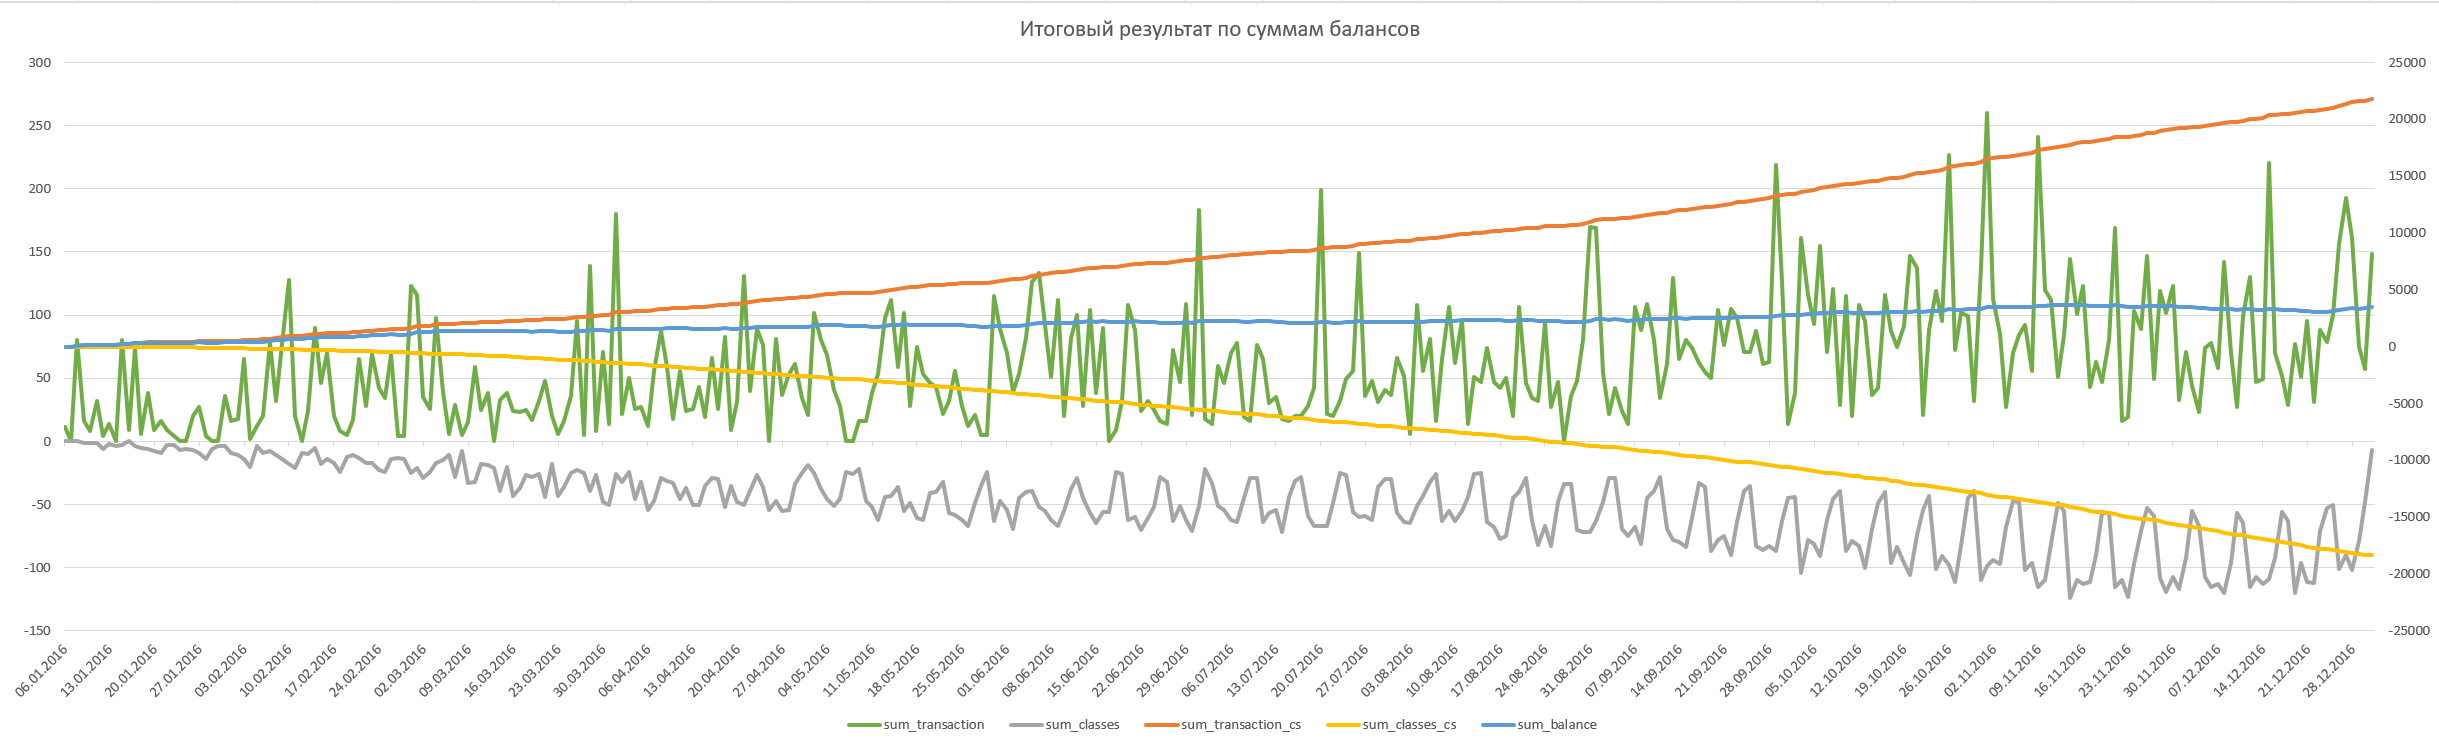